# Estimate Turbine Locations with the Vineyard Wind COP Map

## Assumptions:
- **Consistent Scale**: The map maintains the same scale horizontally and vertically, ensuring uniform measurements.
<!-- - **Map Orientation**: The map is oriented with north at the top. -->
- **Visible Turbines**: Turbines are distinguishable by unique markers or colors.
- **Known Reference Points**: The northernmost and southernmost turbines provide geographic coordinates for vertical calibration.

## Steps to Estimate Turbine Locations:
### 1. Preparation
- **Obtain the Map**: Secure a high-quality digital image of the Vineyard Wind COP map.
- **Determine Scale**: Utilize the known coordinates of the northernmost and southernmost turbines to define the vertical scale, assuming the same for the horizontal due to consistent aspect ratio.

### 2. Image Processing
- **Load Image**: Open the map in an image processing tool (e.g., Python with OpenCV).
- **Isolate Turbines**: Apply filters to distinguish turbine markers based on their color or shape.
- **Detect Positions**: Employ contour detection to find each turbine's position in pixel coordinates.

### 3. Geographic Conversion
- **Reference Calibration**: Use the extreme northernmost and southernmost turbines to align pixel measurements to geographic coordinates.
- **Calculate Coordinates**:
  - Determine the scale in degrees per pixel by comparing the pixel distance between known reference turbines.
  - Convert each turbine’s pixel location to latitude and longitude using the derived scale, taking the reference points as a baseline.


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

# Read the main image
img = cv2.imread('/home/yugao/SWOT_L2/data/external/Vineyardwind_wind_development_area.png')
img_original = img.copy()  # Make a copy of the original image for comparison
# Define the green color range in HSV
lower_green = np.array([40, 100, 100], np.uint8)
upper_green = np.array([80, 255, 255], np.uint8)

# Mask the lower 1/4 of the image to exclude the legend
height = img.shape[0]
mask_height = height - int(height * 0.25)
mask = np.ones(img.shape[:2], dtype="uint8")  # White mask
cv2.rectangle(mask, (0, mask_height), (img.shape[1], height), 0, -1)  # Black mask on the lower 1/4

# Mask the lower 1/4 of the image to exclude the legend
height = img.shape[0]
mask_height = height - int(height * 0.25)
mask = np.ones(img.shape[:2], dtype="uint8")  # White mask
cv2.rectangle(mask, (0, mask_height), (img.shape[1], height), 0, -1)  # Black mask on the lower 1/4

# Apply the mask to the image
img_masked = cv2.bitwise_and(img, img, mask=mask)


# Convert image to HSV color space
hsv = cv2.cvtColor(img_masked, cv2.COLOR_BGR2HSV)

# Create a binary mask where the green turbines are white
mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the centroid of each turbine contour and draw a red circle at each centroid
turbine_centers = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        turbine_centers.append((cX, cY))
        cv2.circle(img, (cX, cY), 5, (255, 0, 0), -1)


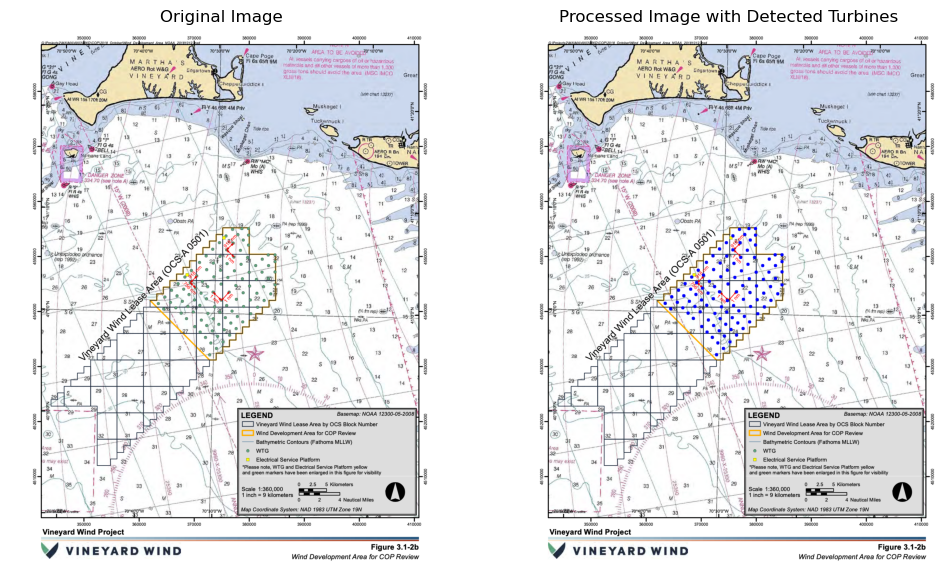

In [16]:
# Convert images to RGB for plotting
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_processed_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the images side by side
plt.figure(figsize=(12, 10))
plt.subplot(121)
plt.imshow(img_original_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(img_processed_rgb)
plt.title('Processed Image with Detected Turbines')
plt.axis('off')

plt.show()

### Known Reference Points: The northernmost and southernmost turbines provide geographic coordinates for vertical calibration, 
### whose latitudes are 40.75 N and 41.17N, respectively. 

In [17]:
# The geographic coordinates of the southeasternmost turbine (based on the estimate)
reference_geo = (40.75, -70.5)

# We now use the southeasternmost turbine as the reference for the lowest latitude
lat_geo_lowest = reference_geo[0]  # Southeasternmost turbine latitude

# The estimated latitude for the northeasternmost turbine
lat_geo_highest = 41.17  # Northeasternmost turbine latitude (based on the estimate)

### Calculate the turbine pixel location

In [18]:
# Initialize variables to store the uppermost and lowermost turbine pixel locations
uppermost_turbine_pixel = None
lowermost_turbine_pixel = None

# Iterate through the detected turbine centers to find the uppermost and lowermost pixels
for center in turbine_centers:
    # Check if the current center is above the uppermost pixel or if uppermost pixel is not set
    if uppermost_turbine_pixel is None  or center[1] < uppermost_turbine_pixel[1]:
        uppermost_turbine_pixel = center
    # Check if the current center is below the lowermost pixel or if lowermost pixel is not set
    if lowermost_turbine_pixel is None or center[1] > lowermost_turbine_pixel[1]:
        lowermost_turbine_pixel = center

# Print the pixel locations of the uppermost and lowermost turbines
print("Uppermost Turbine Pixel Location:", uppermost_turbine_pixel)
print("Lowermost Turbine Pixel Location:", lowermost_turbine_pixel)

Uppermost Turbine Pixel Location: (728, 609)
Lowermost Turbine Pixel Location: (609, 994)


### Calculate the degree per pixel

In [19]:
reference_pixel = lowermost_turbine_pixel

# Placeholder for the height in pixels between the uppermost and lowermost turbine
# This should be calculated based on the actual pixel coordinates
height_in_pixels = uppermost_turbine_pixel[1] - lowermost_turbine_pixel[1]  # Use actual values

# Calculate the difference in latitude between the two points
lat_diff = lat_geo_highest - lat_geo_lowest 

# Calculate the scale in degrees per pixel for vertical (latitude)
# This calculation needs the actual value for height_in_pixels to be accurate
scale_degrees_per_pixel_vertical = lat_diff / height_in_pixels if height_in_pixels != 0 else 0

# Output the height in pixels and the scale in degrees per pixel
height_in_pixels, scale_degrees_per_pixel_vertical

(-385, -0.0010909090909090953)

### calcalte the turbine location

In [20]:
# New scale in degrees per pixel for both vertical and horizontal
scale_degrees_per_pixel = scale_degrees_per_pixel_vertical

# Convert the pixel distances to degrees using the new scale ratio
turbines_geo = []

for center in turbine_centers:
    delta_x = center[0] - reference_pixel[0]
    delta_y = reference_pixel[1] - center[1]  # Y is inverted in image coordinates
    lat = reference_geo[0] - (delta_y * scale_degrees_per_pixel)  # Latitude increases as we go up
    lon = reference_geo[1] - (delta_x * scale_degrees_per_pixel)  # Longitude increases as we go right
    turbines_geo.append({'latitude': lat, 'longitude': lon})

turbines_geo[:5]  # This will be empty unless turbine_centers and reference_pixel are provided with actual values


[{'latitude': 40.75, 'longitude': -70.5},
 {'latitude': 40.77072727272727, 'longitude': -70.4770909090909},
 {'latitude': 40.789272727272724, 'longitude': -70.49563636363636},
 {'latitude': 40.792545454545454, 'longitude': -70.45527272727273},
 {'latitude': 40.807818181818185, 'longitude': -70.51418181818183}]

### Save the turbine locations to a JSON file

In [21]:
# Save the geographic coordinates to a JSON file
json_filename = '/home/yugao/SWOT_L2/data/processed/windturbine/turbines_geo.json'
with open(json_filename, 'w') as json_file:
    json.dump(turbines_geo, json_file)

print(f'The geographic coordinates of the turbines have been saved to {json_filename}')

# Displaying a summary of corrected coordinates
for i, geo in enumerate(turbines_geo[:5], 1):  # Display the first 5 for brevity
    print(f"Turbine {i}: Latitude {geo['latitude']}, Longitude {geo['longitude']}")


The geographic coordinates of the turbines have been saved to /home/yugao/SWOT_L2/data/processed/windturbine/turbines_geo.json
Turbine 1: Latitude 40.75, Longitude -70.5
Turbine 2: Latitude 40.77072727272727, Longitude -70.4770909090909
Turbine 3: Latitude 40.789272727272724, Longitude -70.49563636363636
Turbine 4: Latitude 40.792545454545454, Longitude -70.45527272727273
Turbine 5: Latitude 40.807818181818185, Longitude -70.51418181818183
